In [1]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/'
master_dir = '/home2/glee/dissertation/1_tech_gen_impact/master/Tech_Gen/'
import sys
sys.path.append(root_dir)

import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer, Predictor
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict, to_device

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# PART 1: Configuration

In [2]:
analysis_date = "2023-05-09_0331"
args = argparse.Namespace(
#     data_type="class+claim",
#     data_file=None,
#     target_ipc=None,
#     pred_type="classification",
#     n_TC = 5,
#     use_pretrained_tokenizer=False,
#     do_train=None,
    do_eval = True,
#     do_tune=None,
#     n_folds=None,
#     batch_size=512,
#     max_epochs=20,
#     use_accelerator=None,
    do_save=False,
#     n_gpus=4,
#     light=True,
    config_file=os.path.join(root_dir, "configs", "USED_configs", "[CONFIGS]"+analysis_date+".json"),
#     config_file=None,
    eval_train_set=False)

project_data_dir = os.path.join(master_dir, "data")
data_dir = os.path.join("/home2/glee/patent_data/data/")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

## parse configuration file
# args = parser.parse_args()
if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
if args.do_eval: args.do_train = False
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

# parse command line arguments
instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

## assign loss weights
if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

## assign devices
if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device
    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

## extract configurations for dataset
config_period = "["+"-".join([str(year) for year in configs.data.target_period])+"]"
config_ipcs = str(configs.data.target_ipc).replace("\'","").replace(" ","")
config_keywords = str(configs.data.target_keywords).replace("\'","").replace(" ","")

## update configurations
configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir,
                        "pretrained_enc": configs.model.pretrained_enc,
                        "pretrained_dec": configs.model.pretrained_dec,
                        "data_nrows": None,
                        "data_file": "collection_" + "".join([config_keywords, config_ipcs, config_period]) + ".csv"})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_enc_hidden = configs.model.d_enc_hidden = None
    d_pred_hidden = configs.model.d_pred_hidden = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_enc_hidden = configs.model.d_enc_hidden
    d_pred_hidden = configs.model.d_pred_hidden
    d_latent = configs.model.d_latent

    ## set filename for model
    key_components = {"data": ["ipc_level", "max_seq_len_class", "max_seq_len_claim", "vocab_size"], "model": ["n_layers", "d_hidden", "d_pred_hidden", "d_latent", "d_embedding", "d_ff", "n_head", "d_head"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    model_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
    for key in ["model", "train"]:
        for component in key_components[key]:
            model_config_name += f"[{str(configs[key][component])}]{component}"
    final_model_path = os.path.join(model_dir, f"[MODEL]{model_config_name}.ckpt")

configs.train.update({"model_config_name": model_config_name, "final_model_path": final_model_path})


# PART 2: Dataset setting

In [3]:
''' PART 2: Dataset setting '''
tstart = time.time()
dataset_config_name = "".join([config_keywords, config_ipcs, config_period]) + "data"
for component in key_components["data"]:
    dataset_config_name += f"[{str(configs.data[component])}]{component}"
dataset_path = os.path.join(project_data_dir, "pickled_dataset", "[DATASET]"+dataset_config_name+".pickle")

if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
        if tech_dataset.pretrained_enc != configs.data.pretrained_enc or tech_dataset.pretrained_dec != configs.data.pretrained_dec:
            tech_dataset.pretrained_enc = configs.data.pretrained_enc
            tech_dataset.pretrained_dec = configs.data.pretrained_dec
            tech_dataset.tokenizers = tech_dataset.get_tokenizers()
        for tk in tech_dataset.tokenizers.values():
            if "vocab_size" not in dir(tk):
                tk.vocab_size = tk.get_vocab_size()
        tech_dataset.use_keywords = configs.data.use_keywords
        ## load saved rawdata
        if tech_dataset.rawdata is None:
            tech_dataset.rawdata = pd.read_csv(os.path.join(data_dir, configs.data.data_file), low_memory=False)
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    if args.debug:
        configs.data.update({"data_nrows": 1000})
        dataset_path += ".debug"
    tech_dataset = TechDataset(configs.data)
    if not args.debug:
        rawdata_for_save = copy.deepcopy(tech_dataset.rawdata)
        with open(dataset_path, "wb") as f:
            tech_dataset.rawdata = None
            pickle.dump(tech_dataset, f)
        tech_dataset.rawdata = rawdata_for_save
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

configs.model.update({"tokenizers": tech_dataset.tokenizers,
                    "n_enc_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_dec_seq_claim": tech_dataset.max_seq_len_claim,
                    "n_enc_seq_class": tech_dataset.max_seq_len_class,
                    "n_dec_seq_class": tech_dataset.max_seq_len_class,
                    "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                    "i_padding": tech_dataset.tokenizers["class_enc"].pad_id})

Load pickled dataset...
Pickled dataset loaded
23.2031 sec elapsed for loading patents for class [['G06F']]


## Inference

In [4]:
final_model_path

'/home2/glee/dissertation/1_tech_gen_impact/class2class/Tech_Gen/models/[MODEL][G06F][2007-2012]data[4]n_layers[32]d_hidden[8]d_pred_hidden[32]d_latent[128]d_embedding[16]d_ff[4]n_head[16]d_head[0.0005]learning_rate[256]batch_size[50]max_epochs.ckpt'

In [5]:
final_model = build_model(configs.model, tokenizers=tech_dataset.tokenizers)
if os.path.exists(final_model_path):
    best_states = torch.load(final_model_path)
else:
    raise Exception("Model need to be trained first")
converted_states = OrderedDict()
for k, v in best_states.items():
    if 'module' not in k:
        k = 'module.'+k
    else:
        k = k.replace('features.module.', 'module.features.')
    converted_states[k] = v
final_model.load_state_dict(converted_states)

del best_states
del converted_states
torch.cuda.empty_cache()
print("Model successfully loaded")

Model successfully loaded


In [6]:
result_path = os.path.join(root_dir, "results")

used_train_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TRAIN_dataset")
used_test_data = pd.read_excel(os.path.join(result_path, "[DATASET]"+analysis_date+".xlsx"), sheet_name="TEST_dataset")
used_train_index = tech_dataset.data.index.get_indexer(pd.Index(used_train_data["number"]))
used_test_index = tech_dataset.data.index.get_indexer(pd.Index(used_test_data["number"]))

In [7]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [8]:
batch_size = 16

In [9]:
used_train_dataset = Subset(tech_dataset, used_train_index)
train_loader = DataLoader(used_train_dataset, batch_size=batch_size, drop_last=True)

In [10]:
zs, ys, preds = [], [], []
newzs = []
for batch_data in tqdm(train_loader):
    batch_data = to_device(batch_data, final_model.module.device)
    y = batch_data["targets"].cpu().detach().numpy()
    
    enc_outputs, z, mu, logvar = final_model.module.encode(batch_data["text_inputs"])
    pred_outputs = final_model.module.predictor(z)
    torch.cuda.empty_cache()

    zs.append(z.cpu().detach().numpy())
    ys.append(y)
    preds.append(pred_outputs.argmax(1).cpu().detach().numpy())
    
    torch.cuda.empty_cache()
                                                
zs = np.concatenate(zs)
ys = np.concatenate(ys)
preds = np.concatenate(preds)

100%|██████████| 3884/3884 [06:48<00:00,  9.50it/s]


In [11]:
import datetime
from nltk.translate.bleu_score import sentence_bleu
col_years = ["<1976"] + np.arange(1976,2023).astype(str).tolist()
latest_year = datetime.datetime.now().year - 1
n_TC = configs.data.n_TC

visualize = True

In [12]:
ref_config_period = "[2012-2017]"
ref_data_file = "collection_" + "".join([config_keywords, config_ipcs, ref_config_period]) + ".csv"
ref_configs = copy.deepcopy(configs)
ref_configs.data.update({"target_period": ref_config_period, "data_file": ref_data_file})
ref_dataset = TechDataset(ref_configs.data)




Tokenizer is trained and saved


In [13]:
used_rawdata = tech_dataset.rawdata.set_index("number")
total_data = pd.concat([tech_dataset.data, ref_dataset.data], axis=0)
total_rawdata = pd.concat([tech_dataset.rawdata.set_index("number"), ref_dataset.rawdata.set_index("number")], axis=0)

- Parts of the collected patent database

In [863]:
# sample_index = pd.Index(["7987362", "7613164", "7266663", "7266666", "8327354", "7769767"])
# sample_index = pd.Index(["7523443", "7965656", "8335889", "7324446", "8020096", "7860895"])
sample_index = ["8068433", "8108543", "7739999", "7164981", "7392483", "8001433"]

In [864]:
sample_data = pd.concat([tech_dataset.data.loc[sample_index], tech_dataset.rawdata.set_index("number").loc[sample_index][["forward_refs", "granted_year", "application_year_forward_refs"]]], axis=1)[["claims", "ipcs", "forward_refs", "TC5", "granted_year", "application_year_forward_refs"]]

*TC5는 application이 아니라 granted year 기준!

In [876]:
str(sample_data.iloc[0]["ipcs"]).replace("[","").replace("]","")

"'G08C17', 'H04L12', 'H04L29'"

In [907]:
sample_data2 = copy.deepcopy(sample_data)
sample_data2.loc[:,"new_ipcs"] = sample_data["ipcs"].apply(lambda x: str(x).replace("[","").replace("]","").replace("\'",""))
sample_data2.loc[:,"new_frefs"] = sample_data.apply(lambda x: str(np.array(x["forward_refs"].split(";"))[np.argsort(np.array(x["application_year_forward_refs"].split(";")))[:10]]).replace("[","").replace("]","").replace("\'",""), axis=1)
sample_data3 = sample_data2[['claims', 'new_ipcs', 'new_frefs', 'TC5']]

In [908]:
sample_data3

,claims,new_ipcs,new_frefs,TC5
number,,,,
8068433,1. A computing device comprising: a network in...,"G08C17, H04L12, H04L29",8885531 8683187 8850235 8495399 8495399 873147...,10
8108543,1. A method performed by a controller associat...,"G06F15, G06F13",8406119 8478861 8850410 8689181 9596989 903325...,44
7739999,1. A method to control combustion in a multi-c...,"F02B03, F02M07, G06F07",8099230 8099230 8469002 8826884 10202927 93769...,5
7164981,1. A line pressure variable control method for...,"G06F07, F16H61",7699748 8170762 8170762 8150585 8548699 948826...,4
7392483,1. A method of dynamically transforming graphi...,"G06F03, G06F03, G06F17",7478340 7716568 8396859 8396859 7716568 854394...,54
8001433,1. A method of making a circuit for scan testi...,"G01R31, G06F17",9507406 9183105 9684367 10296077,2


In [14]:
tech_dataset.data["TC5"].describe()

count    69050.000000
mean         5.928834
std         12.282008
min          0.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        310.000000
Name: TC5, dtype: float64

In [15]:
used_test_data["TC5"].describe()

count    6905.000000
mean        5.839392
std        11.656828
min         0.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       183.000000
Name: TC5, dtype: float64

In [16]:
L1_criterion = tech_dataset.data["TC5"].quantile(0.9)

In [144]:
# used_test_data_TC = used_test_data[(used_test_data["TC5"]>0) & (used_test_data["TC5"]<L1_criterion)].reset_index()
used_test_data_TC = used_test_data[used_test_data["TC5"]!=0].reset_index()
used_test_index_TC = tech_dataset.data.index.get_indexer(pd.Index(used_test_data_TC["number"]))

In [909]:
sample_index_techdataset = tech_dataset.data.index.get_indexer(sample_index)

In [910]:
sample_index_techdataset

array([325,  10, 403, 426,  14, 141])

In [911]:
visualize = False

sample_latent_vectors = []
for idx in sample_index_techdataset:
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    
    sample_latent_vectors.append(np.round(z[0].cpu().detach().numpy()[[0,1,2,-3,-2,-1]], 4))

    if visualize:
        zs_for_tsne = np.concatenate([zs[near_mean_idx_], org_z])
        ys_for_tsne = np.concatenate([ys[near_mean_idx_], org_y])
        tsne = TSNE(early_exaggeration=10, learning_rate="auto", n_iter=500, init="random", verbose=0, metric="cosine", square_distances=True)
        z_tsne = tsne.fit_transform(zs_for_tsne)
        plt.scatter(z_tsne[:-1,0], z_tsne[:-1,1], c=ys_for_tsne[:-1], cmap="bwr")
        plt.scatter(z_tsne[-1,0], z_tsne[-1,1], c="k", marker="X")
        plt.text(z_tsne[-1,0]+0.5, z_tsne[-1,1]+0.5, "origin", weight="bold")
        plt.show()

In [916]:
pd.DataFrame(np.array(sample_latent_vectors))

,0,1,2,3,4,5
0,-0.6426,-0.4792,2.1312,-0.7480,0.4175,-0.0635
1,-0.3224,1.0565,-0.2465,-1.7109,2.2470,-0.1508
2,-2.4951,-1.9952,2.5749,0.5984,-1.5886,1.6595
3,-1.9570,-0.3150,0.8557,1.6192,-3.2747,0.7659
4,0.7134,-0.3397,-2.4666,0.3535,1.2611,-1.2745
5,-1.1416,0.2960,-1.5641,-1.6823,-0.2495,-0.6344


In [710]:
pd.DataFrame(sample_data["ipcs"])

,ipcs
7523443,"[G06F09, G06F09]"
7965656,"[H04L12, G06F15, H04L12]"
8335889,"[G06F07, G06F09, G06F12, G11C15]"
7324446,"[G06F11, H04L12]"
8020096,"[G06F03, G06F03, G06F09]"
7860895,"[G06F07, G06F17]"


In [708]:
pd.concat([sample_data["ipcs"], pd.Series(sample_latent_vectors, index=sample_index)], axis=1)

,ipcs,0
7523443,"[G06F09, G06F09]","[-0.1978, -0.9817, -0.5971, -0.6065, -0.4733, ..."
7965656,"[H04L12, G06F15, H04L12]","[-0.873, -0.3401, 0.4811, 0.813, 2.4073, 0.2737]"
8335889,"[G06F07, G06F09, G06F12, G11C15]","[0.4084, -2.1276, 0.5424, 1.5945, 0.2304, -2.2..."
7324446,"[G06F11, H04L12]","[-1.1762, -0.2599, 0.5092, 0.2096, 1.8, -1.1642]"
8020096,"[G06F03, G06F03, G06F09]","[1.3564, -1.7274, -1.5598, -2.5436, 0.1587, -0..."
7860895,"[G06F07, G06F17]","[-0.8987, 0.6724, -1.1416, 0.1959, 0.5211, -0...."


In [145]:
def breakdown(ipcs):
    return ([ipc[0] for ipc in ipcs], [ipc[:3] for ipc in ipcs], [ipc[:4] for ipc in ipcs], ipcs)

In [856]:
def tech_identify(idx=None):
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    true_y = tech_dataset.data.iloc[idx]["TC5_digitized"]
#     display(pd.DataFrame(tech_dataset.data.iloc[idx]).T)
    
    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    tokenizer = tech_dataset.tokenizers["class_dec"]

    org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
    org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]

    n_iter = 30
    step_size = 10

    optimised = False
    optimised_i = 0
    gen_texts, FC_estimateds, FC_estimated_invs, FC_estimated_labels = [], [], [], []
    for i in range(n_iter):
        pred_outputs = final_model.module.predict(z)
        z.retain_grad()
        FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
        FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)

        FC_estimated_label = 1 if FC_estimated>=0.5 else 0
        
        L1_error = (1-torch.exp(pred_outputs[0,1]))
        L1_error.backward(retain_graph=True)

        grad_for_update = (step_size * z.grad)
        z_ = z - grad_for_update

        z.grad.zero_()
        dec_outputs = final_model.module.decode(z_, enc_outputs, dec_inputs=None)
        dec_outputs = dec_outputs.argmax(-1)

        tokenizer = tech_dataset.tokenizers["class_dec"]
        gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
        if tokenizer.eos_token in gen_text:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
        else:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
        if gen_text != []:
            gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
            gen_text = set(gen_text)
        else: continue
            
        gen_texts.append(gen_text)
        FC_estimateds.append(FC_estimated)
        FC_estimated_invs.append(FC_estimated_inv)
        FC_estimated_labels.append(FC_estimated_label)
    
        if FC_estimated>=0.6:
            if set(org_text) == set(gen_text) or set(org_text).union(set(gen_text))==set(org_text): return
#             if not optimised: print("-"*60)
            optimised = True
            optimised_i = i
        z = z_

    if true_y != FC_estimated_labels[0] or set(org_text) != set(gen_texts[0]) or not optimised:
        return
    else:
        display(pd.DataFrame(tech_dataset.data.iloc[idx]).T)
                
    for i in range(n_iter):        
        if i < 4 or i > 26:
            print(f"<< Iteration {i} >>")
            print(f"Original Label: {true_y}, Estimated prob. for L1 (L2): {FC_estimateds[i]} ({FC_estimated_invs[i]})")
            print("Original class:\n",set(org_text),"\nGenerated class:\n", gen_texts[i])

In [857]:
for idx in range(500):
    tech_identify(idx)

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8181118,8181118,G06F03,"[G06F03, G06F13]","[G06F03, G06F03, G06F13]",1. A method comprising: during boot-up of a mo...,3,0,82


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.2768 (0.7232)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G06F13', 'G06F03'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.5592 (0.4408)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.7366 (0.2634)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.8099 (0.1901)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9593 (0.0407)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9607 (0.0393)
Original class:
 {'G06F13', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 29 >>
Original Label: 0, 

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8051124,8051124,G06F07,[G06F07],"[G06F07, G06F07]",1. A matrix multiplication device for computin...,2,0,82


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.1658 (0.8342)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F07'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.2756 (0.7244)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F07'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.5221 (0.4779)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F07'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.6412 (0.3588)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F03', 'G06F07'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9513 (0.0487)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F03', 'G06F07'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9532 (0.0468)
Original class:
 {'G06F07'} 
Generated class:
 {'G06F03', 'G06F07'}
<< Iteration 29 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.955 (0.045)
Original class:
 {'G06F07'} 
Generated class:
 

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8001433,8001433,G01R31,[G06F17],"[G01R31, G06F17]",1. A method of making a circuit for scan testi...,2,0,77


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.1971 (0.8029)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G01R31', 'G06F17'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.3768 (0.6232)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G01R31', 'G06F17'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.5846 (0.4154)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G01R31', 'G06F17'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.6355 (0.3645)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G06F17', 'G01C21'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9543 (0.0457)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G09G05', 'G06F03', 'G01C21'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.956 (0.044)
Original class:
 {'G01R31', 'G06F17'} 
Generated class:
 {'G09G05', 'G06F03', 'G01C21'}
<< Iteration 29 >>
O

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8040296,8040296,G09G03,[G06F03],"[G09G03, G06F03]",1. A plasma display device comprising: a plasm...,0,0,85


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.1882 (0.8118)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G03', 'G06F03'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.3802 (0.6198)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G05', 'G09G03', 'G06F03'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.593 (0.407)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G03', 'G06F03'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.7097 (0.2903)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G05', 'G09G03', 'G06F03'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9546 (0.0454)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9563 (0.0437)
Original class:
 {'G09G03', 'G06F03'} 
Generated class:
 {'G09G05', 'G06F03'}
<< Iteration 29 >>
O

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8068433,8068433,G08C17,"[H04L12, H04L29]","[G08C17, H04L12, H04L29]",1. A computing device comprising: a network in...,10,0,84


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.3962 (0.6038)
Original class:
 {'G08C17', 'H04L12', 'H04L29'} 
Generated class:
 {'G08C17', 'H04L12', 'H04L29'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.528 (0.472)
Original class:
 {'G08C17', 'H04L12', 'H04L29'} 
Generated class:
 {'G08C17', 'H04L29'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.6139 (0.3861)
Original class:
 {'G08C17', 'H04L12', 'H04L29'} 
Generated class:
 {'G08C17', 'H04L29', 'H04W36'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.6921 (0.3079)
Original class:
 {'G08C17', 'H04L12', 'H04L29'} 
Generated class:
 {'G08C17', 'H04L29', 'H04Q07'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9545 (0.0455)
Original class:
 {'G08C17', 'H04L12', 'H04L29'} 
Generated class:
 {'H04W36', 'H04W24'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9562 (0.0438)
Original class:
 {'G08C17', 'H04L12', 

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
7739999,7739999,F02B03,"[F02M07, G06F07]","[F02B03, F02M07, G06F07]",1. A method to control combustion in a multi-c...,5,0,62


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.175 (0.825)
Original class:
 {'F02B03', 'F02M07', 'G06F07'} 
Generated class:
 {'F02B03', 'F02M07', 'G06F07'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.3004 (0.6996)
Original class:
 {'F02B03', 'F02M07', 'G06F07'} 
Generated class:
 {'F02B03', 'F02M07', 'G06F07'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.5685 (0.4315)
Original class:
 {'F02B03', 'F02M07', 'G06F07'} 
Generated class:
 {'F02B03', 'F02M07', 'G06F07'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.7527 (0.2473)
Original class:
 {'F02B03', 'F02M07', 'G06F07'} 
Generated class:
 {'G03H01', 'G06F07'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9587 (0.0413)
Original class:
 {'F02B03', 'F02M07', 'G06F07'} 
Generated class:
 {'G06F19', 'G03H01', 'A61C03', 'G06F07'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.9601 (0.0399)
Original class:
 {

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
7164981,7164981,G06F07,[F16H61],"[G06F07, F16H61]",1. A line pressure variable control method for...,4,0,82


<< Iteration 0 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.2358 (0.7642)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'F16H61', 'G06F07'}
<< Iteration 1 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.3287 (0.6713)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'F16H61', 'G06F07'}
<< Iteration 2 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.431 (0.569)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'G06F17', 'G06F07'}
<< Iteration 3 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.4591 (0.5409)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'G06F17', 'G06F07'}
<< Iteration 27 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.87 (0.13)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'G06F03', 'G01C21'}
<< Iteration 28 >>
Original Label: 0, Estimated prob. for L1 (L2): 0.8755 (0.1245)
Original class:
 {'F16H61', 'G06F07'} 
Generated class:
 {'G06F03', 'G01C21'}
<< Iteration 29 >>
Original Label: 0, Estima

In [861]:
def tech_identify_same(idx=None):
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    true_y = tech_dataset.data.iloc[idx]["TC5_digitized"]
#     display(pd.DataFrame(tech_dataset.data.iloc[idx]).T)
    
    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    tokenizer = tech_dataset.tokenizers["class_dec"]

    org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
    org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]

    n_iter = 30
    step_size = 10

    optimised = False
    optimised_i = 0
    gen_texts, FC_estimateds, FC_estimated_invs, FC_estimated_labels = [], [], [], []
    for i in range(n_iter):
        pred_outputs = final_model.module.predict(z)
        z.retain_grad()
        FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
        FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)

        FC_estimated_label = 1 if FC_estimated>=0.5 else 0
        
        L1_error = (1-torch.exp(pred_outputs[0,1]))
        L1_error.backward(retain_graph=True)

        grad_for_update = (step_size * z.grad)
        z_ = z - grad_for_update

        z.grad.zero_()
        dec_outputs = final_model.module.decode(z_, enc_outputs, dec_inputs=None)
        dec_outputs = dec_outputs.argmax(-1)

        tokenizer = tech_dataset.tokenizers["class_dec"]
        gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
        if tokenizer.eos_token in gen_text:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
        else:
            gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
        if gen_text != []:
            gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
            gen_text = set(gen_text)
        else: continue
            
        gen_texts.append(gen_text)
        FC_estimateds.append(FC_estimated)
        FC_estimated_invs.append(FC_estimated_inv)
        FC_estimated_labels.append(FC_estimated_label)
    
        if FC_estimated>=0.6:
#             if set(org_text) == set(gen_text) or set(org_text).union(set(gen_text))==set(org_text): return
            optimised = True
            optimised_i = i
        z = z_

    if true_y==0 or true_y != FC_estimated_labels[0] or set(org_text) != set(gen_texts[0]) or not optimised:
        return
    else:
        display(pd.DataFrame(tech_dataset.data.iloc[idx]).T)
                
    for i in range(n_iter):        
        if i < 4 or i > 26:
            print(f"<< Iteration {i} >>")
            print(f"Original Label: {true_y}, Estimated prob. for L1 (L2): {FC_estimateds[i]} ({FC_estimated_invs[i]})")
            print("Original class:\n",set(org_text),"\nGenerated class:\n", gen_texts[i])

In [862]:
for idx in range(50):
    tech_identify_same(idx)

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
8108543,8108543,G06F15,[G06F13],"[G06F15, G06F13]",1. A method performed by a controller associat...,44,1,82


<< Iteration 0 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.5221 (0.4779)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13'}
<< Iteration 1 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.6133 (0.3867)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13'}
<< Iteration 2 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.6678 (0.3322)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13'}
<< Iteration 3 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.6921 (0.3079)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13'}
<< Iteration 27 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.9171 (0.0829)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13', 'H04M11'}
<< Iteration 28 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.9199 (0.0801)
Original class:
 {'G06F15', 'G06F13'} 
Generated class:
 {'G06F15', 'G06F13', 'H04N05'}
<< Iteration 29 >>

,number,main_ipc,sub_ipc,ipcs,claims,TC5,TC5_digitized,class
7392483,7392483,G06F03,"[G06F03, G06F17]","[G06F03, G06F03, G06F17]",1. A method of dynamically transforming graphi...,54,1,82


<< Iteration 0 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.5859 (0.4141)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 1 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.7054 (0.2946)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 2 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.7898 (0.2102)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 3 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.8288 (0.1712)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 27 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.9597 (0.0403)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 28 >>
Original Label: 1, Estimated prob. for L1 (L2): 0.9611 (0.0389)
Original class:
 {'G06F03', 'G06F17'} 
Generated class:
 {'G06F03', 'G06F17'}
<< Iteration 29 >>
Original Label: 1, 

In [858]:
# sample_index2 = pd.Index(["8217679", "8160403", "7268581", "8265788", "8068433",
#                  "8335924", "8321806", "7551626", "8131083"])
# sample_index2_techdataset = tech_dataset.data.index.get_indexer(sample_index2)
# for idx in sample_index2_techdataset:
#     tech_identify(idx)

In [219]:
def validate_reliability(idx=None):
    cnt_nonexist = 0
    cnt_noFC = 0
    cnt_diverge = 0
    cnt_same_ipcs = 0
    
    input_class = torch.tensor(tech_dataset.tokenizers["class_enc"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    input_claim = tech_dataset.tokenize(tech_dataset.tokenizers["claim_enc"], tech_dataset.X_claim[used_test_index_TC][idx])
    input_claim = {k: v.unsqueeze(0) for k, v in input_claim.items()}
    batch_input = {"class": torch.tensor(input_class), "claim": input_claim}
    input_inf = to_device(batch_input, final_model.module.device)

    output_class = torch.tensor(tech_dataset.tokenizers["class_dec"].encode(tech_dataset.X_class[used_test_index_TC][idx])).unsqueeze(0)
    batch_output = {"text_outputs": torch.tensor(output_class)}
    output_inf = to_device(batch_output, final_model.module.device)

    near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:2500]
    near_mean_idx_ = np.union1d(near_mean_idx, np.random.choice(np.where(ys==1)[0], 50))
    enc_outputs, z, mu, logvar = final_model.module.encode(input_inf)
    org_z = copy.deepcopy(z.view(1,-1).cpu().detach().numpy())
    pred_outputs = final_model.module.predict(z)
    org_y = copy.deepcopy(pred_outputs.argmax(1).cpu().detach().numpy())
    dec_inputs = None

    if used_test_data_TC.iloc[idx]["TC5"] > 0:
        forward_refs = used_rawdata.loc[used_test_data_TC.iloc[idx]["number"]]["forward_refs"].split(";")
        ref_info = total_data.loc[[ref for ref in forward_refs if ref in total_data.index]]
        if len(ref_info) == 0:
#             print("Dataset does not have information about citing patents")
            cnt_nonexist += 1
            return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
        else:
            ref_ipcs = ref_info["ipcs"].apply(lambda x: set(x))
            ref_FCs = ref_info["TC"+str(n_TC)]

            tokenizer = tech_dataset.tokenizers["class_dec"]
            
            org_text = tokenizer.decode_batch(input_class.cpu().detach().numpy())[0]
            org_text = org_text[org_text.index(tokenizer.sos_token)+1:org_text.index(tokenizer.eos_token)]
            if set(org_text)==set(np.concatenate(ref_ipcs.apply(lambda x: list(x)).values)):
                cnt_same_ipcs += 1
#                 cnt_same_ipcs -= 1
#                 return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
            
            n_iter = 30
            step_size = 40

            inclusions = [None, None, None, None]
            higher_impacts = [None, None, None, None]
            similar_refs_out = [None, None, None, None]
            unsimilar_refs_out = [None, None, None, None]
            optimised = False
            for i in range(n_iter):
                pred_outputs = final_model.module.predict(z)
                z.retain_grad()
                FC_estimated = np.round(np.exp(pred_outputs[0,1].item()), 4) # estimated forward citations
                FC_estimated_inv = np.round(np.exp(pred_outputs[0,0].item()), 4)
                
                L1_error = (1-torch.exp(pred_outputs[0,1]))
                L1_error.backward(retain_graph=True)
#                 (1-pred_outputs[0,1]).backward(retain_graph=True)

                grad_for_update = (step_size * z.grad)
                z_ = z - grad_for_update

                z.grad.zero_()
                dec_outputs = final_model.module.decode(z_, enc_outputs, dec_inputs=None)
                dec_outputs = dec_outputs.argmax(-1)

                tokenizer = tech_dataset.tokenizers["class_dec"]
                gen_text = tokenizer.decode_batch(dec_outputs.cpu().detach().numpy())[0]
                if tokenizer.eos_token in gen_text:
                    gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:gen_text.index(tokenizer.eos_token)]
                else:
                    gen_text = gen_text[gen_text.index(tokenizer.sos_token)+1:]
                if gen_text != []:
                    gen_text = [gen_text[0]] + list(np.array(gen_text[1:])[np.unique(gen_text[1:], return_index=True)[1]])                
                    gen_text = set(gen_text)
                else: continue
                
#                 if not np.array_equal(org_text, gen_text) and FC_estimated>=0.5:
                if FC_estimated>=0.6:
#                 if not np.array_equal(org_text, gen_text):
#                 if set(org_text)!=set(gen_text) and FC_estimated>=0.5:
                    optimised = True
#                     print(f"<< Iteration {i+1} >>")
#                     print(f"Estimated prob. for L1 (L2): {FC_estimated} ({FC_estimated_inv})")
#                     print("Original class:\n",org_text,"\nGenerated class:\n", gen_text)
    
                    gen_text_breakdown = breakdown(gen_text)
                    ref_ipcs_breakdown = (ref_ipcs.apply(lambda x: breakdown(x)[0]), ref_ipcs.apply(lambda x: breakdown(x)[1]), ref_ipcs.apply(lambda x: breakdown(x)[2]), ref_ipcs)
            
                    for i in range(4):
                        if inclusions[i] is not None: continue
                        temp_gen_text = gen_text_breakdown[i]
                        temp_ref_ipcs = ref_ipcs_breakdown[i]
                    
                        hit_index = temp_ref_ipcs.apply(lambda x: 1 if set(x)==set(temp_gen_text) else 0)==1
                        similar_refs = temp_ref_ipcs[hit_index].index
                        similar_refs_out[i] = similar_refs
                        unsimilar_refs = temp_ref_ipcs[~hit_index].index
                        unsimilar_refs_out[i] = unsimilar_refs
                        if len(similar_refs) == 0:
                            inclusions[i] = 0
                            higher_impacts[i] = None
#                             print("Generated IPCs are not in citing patents' IPCs")
                        elif len(unsimilar_refs) == 0:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            if similar_mean_FC <= 0:
                                higher_impacts[i] = 0
                            else:
                                higher_impacts[i] = 1
#                             print(f"similar patents' FCs: {np.round(similar_mean_FC, 4)}, no unsimilar patent")
                        else:
                            inclusions[i] = 1
                            similar_mean_FC = np.mean(ref_FCs.loc[similar_refs])
                            unsimilar_mean_FC = np.mean(ref_FCs.loc[unsimilar_refs])
                            if similar_mean_FC >= unsimilar_mean_FC:
                                if similar_mean_FC <= 0:
                                    higher_impacts[i] = None
                                else:
                                    higher_impacts[i] = 1
                            else:
                                higher_impacts[i] = 0
#                             print(f"similar patents' FCs: {np.round(similar_mean_FC, 4)}, unsimilar patents' FCs: {np.round(unsimilar_mean_FC, 4)}")
#                         if higher_impact==1:
#                             print(f"Generated IPCs have higher impact")
                    if None not in inclusions:
                        break
                z = z_
            if optimised:
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), {"index": idx, "patent_id": used_test_data_TC.iloc[idx]["number"], 
                         "org_text": org_text, "gen_text": gen_text, "ref_ipcs": ref_ipcs, "ref_FCs": ref_FCs,
                         "inclusions": inclusions, "higher_impacts": higher_impacts, 
                         "FC_estimated": FC_estimated,
                         "similar_refs": similar_refs_out, "unsimilar_refs": unsimilar_refs_out}
            else:
                cnt_diverge += 1
                return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None
    else:
        pass
#         print("Input patent does not have forward citation")
        cnt_noFC += 1
        return (cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs), None

In [220]:
cnt_nonexist, cnt_noFC, cnt_diverge, cnt_same_ipcs = 0, 0, 0, 0
dict_out = {"index": [], "patent_id": [], "org_text": [], "gen_text": [], "ref_ipcs": [], "ref_FCs": [],
            "inclusions": [], "higher_impacts": [], "FC_estimated": [], "similar_refs": [], "unsimilar_refs": []}
for idx in tqdm(range(len(used_test_index_TC))):
# for idx in tqdm(range(500)):
    cnts, results = validate_reliability(idx)
    cnt_nonexist += cnts[0]
    cnt_noFC += cnts[1]
    cnt_diverge += cnts[2]
    cnt_same_ipcs += cnts[3]
    
    if results is not None:
        for k,v in results.items():
#             if v is not None:
            dict_out[k].append(v)
    
for k, v in dict_out.items():
    dict_out[k] = np.array(v)

100%|██████████| 5205/5205 [08:41<00:00,  9.97it/s]


In [221]:
print("#total:",idx+1)
print("#valid data:",len(dict_out["index"]))
print("#nonexist data:",cnt_nonexist)
print("#no forward citations:",cnt_noFC)
print("#diverged:",cnt_diverge)
print("#same ipcs:",cnt_same_ipcs)
print("\n")
for i in range(4):
    inclusions = np.array(dict_out["inclusions"])[:,i]
    ratio_included = np.round(len(inclusions[inclusions==1])/len(inclusions), 4)
    higher_impacts = np.array(dict_out["higher_impacts"])[:,i][np.array(dict_out["higher_impacts"])[:,i] != None]
    ratio_higher_impact = np.round(len(higher_impacts[higher_impacts==1])/len(higher_impacts), 4)
    print(f"for level {i+1}, Ratio generated IPCs are included in citing patents: {ratio_included}")
    print(f"for level {i+1}, Ratio generated IPCs have higher impact than other citing patents: {ratio_higher_impact}")
    print("\n")

#total: 5205
#valid data: 4143
#nonexist data: 1048
#no forward citations: 0
#diverged: 14
#same ipcs: 185


for level 1, Ratio generated IPCs are included in citing patents: 0.7632
for level 1, Ratio generated IPCs have higher impact than other citing patents: 0.6563


for level 2, Ratio generated IPCs are included in citing patents: 0.6107
for level 2, Ratio generated IPCs have higher impact than other citing patents: 0.6203


for level 3, Ratio generated IPCs are included in citing patents: 0.4574
for level 3, Ratio generated IPCs have higher impact than other citing patents: 0.6139


for level 4, Ratio generated IPCs are included in citing patents: 0.1458
for level 4, Ratio generated IPCs have higher impact than other citing patents: 0.4798




In [550]:
604/4143

0.14578807627323195

In [222]:
temp_inclusions = np.array(dict_out["inclusions"])[np.array(dict_out["inclusions"])[:,-1]==0]

In [223]:
temp_inclusions = np.array(dict_out["inclusions"])[np.array(dict_out["inclusions"])[:,-1]==0]
for i in range(3):
    temp_ratio = len(temp_inclusions[temp_inclusions[:,i]==0]) / len(temp_inclusions)
    print(f"for level {i+1}, Hit ratio when level 4 is not hit: {np.round(temp_ratio,4)}")

for level 1, Hit ratio when level 4 is not hit: 0.2772
for level 2, Hit ratio when level 4 is not hit: 0.4558
for level 3, Hit ratio when level 4 is not hit: 0.6352


In [224]:
from scipy.stats import ttest_ind
whole_patent_classes = tech_dataset.data["ipcs"].apply(lambda x: set(x))

hit_similar_FCs, hit_unsimilar_FCs, hit_diff_FCs = [], [], []
hit_similar_FCs_mean, hit_unsimilar_FCs_mean = [], []
hit_similar_FCs_rank = []
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
hit_samples_index = dict_out["inclusions"][:,-1]==1

hit_patent_ids = dict_out["patent_id"][hit_samples_index]
hit_similar_refs = dict_out["similar_refs"][hit_samples_index][:,-1]
hit_unsimilar_refs = dict_out["unsimilar_refs"][hit_samples_index][:,-1]
for i in range(len(hit_patent_ids)):
    hit_FCs = dict_out["ref_FCs"][hit_samples_index][i]
    hit_FCs = hit_FCs.loc[~hit_FCs.index.duplicated(keep="first")]
    hit_similar_FC = hit_FCs.loc[hit_similar_refs[i].drop_duplicates()]
#     hit_similar_FC = hit_similar_FC.drop_duplicates()
    hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[hit_similar_refs[i].drop_duplicates()]
#     hit_similar_FC_rank = hit_similar_FC_rank.drop_duplicates()
    hit_unsimilar_FC = hit_FCs.loc[hit_unsimilar_refs[i].drop_duplicates()]
#     hit_unsimilar_FC = hit_unsimilar_FC.drop_duplicates()
    if len(hit_unsimilar_FC)>0:
        hit_diff_FC = hit_similar_FC.mean() - hit_unsimilar_FC.mean()
    else:
        hit_diff_FC = hit_similar_FC.mean()
    
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][hit_samples_index][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][hit_samples_index][i])].index]["TC5"]
    if len(org_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    else:
        whole_FC_diff = gen_whole_FC.mean()
    
    hit_similar_FCs.append(hit_similar_FC)
    hit_similar_FCs_rank.append(hit_similar_FC_rank)
    hit_similar_FCs_mean.append(hit_similar_FC.mean())
    hit_unsimilar_FCs.append(hit_unsimilar_FC)
    if len(hit_unsimilar_FC)>0:
        hit_unsimilar_FCs_mean.append(hit_unsimilar_FC.mean())
    else:
        hit_unsimilar_FCs_mean.append(0)
    hit_diff_FCs.append(hit_diff_FC)
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
#     if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
#         print(org_whole_FC, gen_whole_FC)
#         print(ttest_res)
    
    whole_FC_ttest["statistic"].append(ttest_res.statistic)
    whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
    if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
        whole_FCs_diff.append(whole_FC_diff)
    
hit_similar_FCs = np.concatenate(hit_similar_FCs)
hit_similar_FCs_rank = np.concatenate(hit_similar_FCs_rank)
hit_similar_FCs_mean = np.array(hit_similar_FCs_mean)
hit_unsimilar_FCs = np.concatenate(hit_unsimilar_FCs)
hit_unsimilar_FCs_mean = np.array(hit_unsimilar_FCs_mean)
hit_diff_FCs = np.array(hit_diff_FCs)

print("Distribution of forward citations (hit)\n",pd.Series(hit_similar_FCs).describe(),"\n")
print("Distribution of forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs).describe(),"\n")
print("Distribution of mean forward citations (hit)\n",pd.Series(hit_similar_FCs_mean).describe(),"\n")
print("Distribution of mean forward citations (not hit)\n",pd.Series(hit_unsimilar_FCs_mean).describe(),"\n")
print("Distribution of difference of forward citations\n",pd.Series(hit_diff_FCs).describe(),"\n")

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Distribution of forward citations (hit)
 count    1338.000000
mean        8.005232
std        16.777103
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max       157.000000
dtype: float64 

Distribution of forward citations (not hit)
 count    5512.000000
mean       14.530479
std        32.858911
min         0.000000
25%         1.000000
50%         3.000000
75%        12.000000
max       419.000000
dtype: float64 

Distribution of mean forward citations (hit)
 count    604.000000
mean       6.623155
std       13.366468
min        0.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      137.000000
dtype: float64 

Distribution of mean forward citations (not hit)
 count    604.000000
mean       6.025148
std       11.085297
min        0.000000
25%        0.500000
50%        2.666667
75%        6.500000
max      118.308642
dtype: float64 

Distribution of difference of forward citations
 count    604.000000
mean       0.598007
std  

In [226]:
cnt_same, cnt_diff = 0, 0
ranks_same, ranks_diff = [], []
value_same, value_diff = [], []
org_patents_same, org_patents_diff = [], []
cols_val = ["patent_id", "org_ipcs", "org_FC", "gen_ipcs", "is_same", 
            "forward_ref", "ref_ipcs", "ref_FC", "ref_FC_rank"]
df_val = pd.DataFrame(columns=cols_val)
hit_similar_refs = dict_out["similar_refs"][hit_samples_index][:,-1]

for i in tqdm(range(len(dict_out["ref_ipcs"][hit_samples_index]))):
    pid = dict_out["patent_id"][hit_samples_index][i]
    org_FC = tech_dataset.data.loc[pid]["TC5"]
    orgs = set(dict_out["org_text"][dict_out["inclusions"][:,-1]==1][i])
    gens = set(dict_out["gen_text"][dict_out["inclusions"][:,-1]==1][i])
    is_same = 1 if orgs==gens or orgs.union(gens)==orgs else 0
    hit_FCs = dict_out["ref_FCs"][hit_samples_index][i]
    hit_FCs = hit_FCs.loc[~hit_FCs.index.duplicated(keep="first")]
    hit_similar_FC = hit_FCs.loc[hit_similar_refs[i][hit_similar_refs[i].duplicated()]]
#     hit_similar_FC = hit_similar_FC.drop_duplicates()
    hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[hit_similar_refs[i][hit_similar_refs[i].duplicated()]]
#     hit_similar_FC_rank = hit_similar_FC_rank.drop_duplicates()
    
    for ref in hit_similar_refs[i].drop_duplicates():
        ref_ipcs = dict_out["ref_ipcs"][hit_samples_index][i].loc[ref]
        if isinstance(ref_ipcs, pd.Series): ref_ipcs = ref_ipcs[0]
        hit_similar_FC = hit_FCs.loc[ref]
        if isinstance(hit_similar_FC, pd.Series): hit_similar_FC = hit_similar_FC[0]
        hit_similar_FC_rank = hit_FCs.rank(pct=True).loc[ref]
        if isinstance(hit_similar_FC_rank, pd.Series): hit_similar_FC_rank = hit_similar_FC_rank[0]
        
        df_container = pd.DataFrame([[pid, orgs, org_FC, gens, is_same, ref, ref_ipcs, hit_similar_FC, hit_similar_FC_rank]], columns=cols_val)
        df_val = pd.concat([df_val, df_container])

df_val = df_val.set_index("patent_id")

100%|██████████| 604/604 [00:03<00:00, 177.35it/s]


In [241]:
df_val

,org_ipcs,org_FC,gen_ipcs,is_same,forward_ref,ref_ipcs,ref_FC,ref_FC_rank
patent_id,,,,,,,,
7523443,{G06F09},1,{G06F09},1,9652207,{G06F09},4,0.750000
7523443,{G06F09},1,{G06F09},1,9639335,{G06F09},1,0.500000
7523443,{G06F09},1,{G06F09},1,9696974,{G06F09},12,1.000000
7523443,{G06F09},1,{G06F09},1,9563412,{G06F09},0,0.250000
7418663,"{G06F03, G06F17, G06F07}",20,"{G06F03, G06F17}",1,9678933,"{G06F03, G06F17}",2,0.229730
...,...,...,...,...,...,...,...,...
8159971,"{G06F15, H04L12}",1,"{G06F15, H04L12}",1,9237073,"{G06F15, H04L12}",0,1.000000
7921184,"{G06F15, G06F13}",22,{G06F15},1,8499057,{G06F15},8,0.900000
7860895,"{G06F17, G06F07}",26,"{G06F17, G06F07}",1,8793265,"{G06F17, G06F07}",13,0.714286


In [551]:
L1_criterion = tech_dataset.data["TC5"].quantile(0.9)
print("total hit:", len(df_val))
print("same:",len(df_val[df_val["is_same"]==1]))
print("diff:",len(df_val[df_val["is_same"]==0]))
print("over L1 criterion:", len(df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]))
print("ratio:",len(df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]) / len(df_val[df_val["is_same"]==0]))

total hit: 1338
same: 1274
diff: 64
over L1 criterion: 15
ratio: 0.234375


In [229]:
## 인용 IPC 중 생성 IPC와 동일한 게 있으면서, 입력 IPC와 생성 IPC가 다르고, 피인용수가 전체 데이터셋의 L1 기준인 9 이상인 샘플
df_val[df_val["is_same"]==0][df_val[df_val["is_same"]==0]["ref_FC"]>=L1_criterion]

,org_ipcs,org_FC,gen_ipcs,is_same,forward_ref,ref_ipcs,ref_FC,ref_FC_rank
patent_id,,,,,,,,
7461101,"{G06F12, G06F17}",5,"{G06F12, G06F13}",0,8112605,"{G06F12, G06F13}",38,0.818182
7461101,"{G06F12, G06F17}",5,"{G06F12, G06F13}",0,8661216,"{G06F12, G06F13}",40,0.909091
7461101,"{G06F12, G06F17}",5,"{G06F12, G06F13}",0,8266406,"{G06F12, G06F13}",44,1.000000
7461059,"{G10L15, G06F17}",53,"{G10L15, G10L21, G06F17}",0,8849670,"{G10L15, G10L21, G06F17}",54,0.772727
7461059,"{G10L15, G06F17}",53,"{G10L15, G10L21, G06F17}",0,7917367,"{G10L15, G10L21, G06F17}",138,0.916667
7600135,"{G06F09, G06F01}",11,"{G06F09, G06F15, G06F01}",0,7844839,"{G06F09, G06F15, G06F01}",35,1.000000
7665088,"{G06F09, G06F13}",23,"{G06F09, G06F15}",0,8631066,"{G06F15, G06F09}",19,0.888889
7958125,"{G06F17, G06F07}",5,"{G06F03, G06F17}",0,8578274,"{G06F03, G06F17}",35,1.000000
7818282,{G06F17},2,"{G10L15, G06F17}",0,8725496,"{G10L15, G06F17}",19,1.000000


- Patent_matched 전체

In [557]:
df_val["ref_FC"].astype(float).describe()

count    1338.000000
mean        8.005232
std        16.777103
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max       157.000000
Name: ref_FC, dtype: float64

In [555]:
df_val["ref_FC_rank"].astype(float).describe()

count    1338.000000
mean        0.603604
std         0.287665
min         0.032143
25%         0.357143
50%         0.600000
75%         0.859023
max         1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

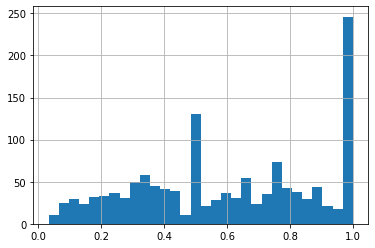

In [554]:
df_val["ref_FC_rank"].astype(float).hist(bins=30)

- IPC_original == IPC_identified

In [543]:
df_val[df_val["is_same"]==1]["ref_FC"].astype(int).describe()

count    1274.000000
mean        7.653846
std        15.876793
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max       157.000000
Name: ref_FC, dtype: float64

In [545]:
df_val[df_val["is_same"]==1]["ref_FC_rank"].astype(float).describe()

count    1274.000000
mean        0.603812
std         0.285860
min         0.032143
25%         0.357143
50%         0.600000
75%         0.857143
max         1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

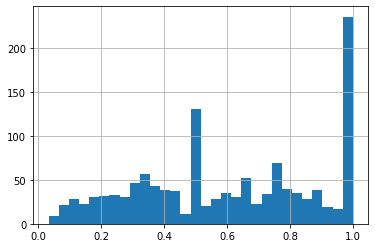

In [238]:
df_val[df_val["is_same"]==1]["ref_FC_rank"].astype(float).hist(bins=30)

- IPC_original != IPC_identified

In [544]:
df_val[df_val["is_same"]==0]["ref_FC"].astype(int).describe()

count     64.000000
mean      15.000000
std       28.771128
min        0.000000
25%        0.750000
50%        3.000000
75%       12.250000
max      139.000000
Name: ref_FC, dtype: float64

In [231]:
df_val[df_val["is_same"]==0]["ref_FC_rank"].astype(float).describe()

count    64.000000
mean      0.599472
std       0.323972
min       0.050000
25%       0.305769
50%       0.712500
75%       0.878472
max       1.000000
Name: ref_FC_rank, dtype: float64

<AxesSubplot:>

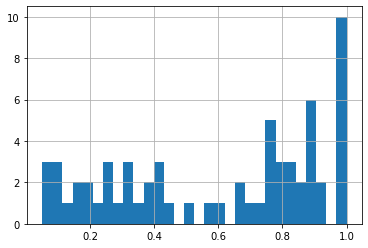

In [237]:
df_val[df_val["is_same"]==0]["ref_FC_rank"].astype(float).hist(bins=30)

In [242]:
analysis_date

'2023-05-09_0331'

In [243]:
if not os.path.exists("../results/validation/"+analysis_date):
    os.mkdir("../results/validation/"+analysis_date)
with open("../results/validation/"+analysis_date+"/dict_out.pickle", "wb") as f:
    pickle.dump(dict_out, f)
with open("../results/validation/"+analysis_date+"/df_val.pickle", "wb") as f:
    pickle.dump(df_val, f)

In [244]:
from scipy.stats import ttest_ind
whole_FC_ttest = {"statistic": [], "pvalue": []}
whole_FCs_diff = []
for i in tqdm(range(len(dict_out["patent_id"]))):
    org_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["org_text"][i])].index]["TC5"]
    gen_whole_FC = tech_dataset.data.loc[whole_patent_classes[whole_patent_classes==set(dict_out["gen_text"][i])].index]["TC5"]
    
#     print(org_whole_FC, gen_whole_FC)
    
    if len(org_whole_FC)>0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean() - org_whole_FC.mean()
    elif len(org_whole_FC)==0 and len(gen_whole_FC)>0:
        whole_FC_diff = gen_whole_FC.mean()
    elif len(org_whole_FC)>0 and len(gen_whole_FC)==0:
        whole_FC_diff = org_whole_FC.mean()
    else:
        whole_FC_diff = 0.0
    
    ttest_res = ttest_ind(gen_whole_FC, org_whole_FC, equal_var=False)
#     if set(dict_out["org_text"][hit_samples_index][i]) != set(dict_out["gen_text"][hit_samples_index][i]):
#         print(org_whole_FC, gen_whole_FC)
#         print(ttest_res)
    if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):    
        whole_FC_ttest["statistic"].append(ttest_res.statistic)
        whole_FC_ttest["pvalue"].append(ttest_res.pvalue)
        if set(dict_out["org_text"][i]) != set(dict_out["gen_text"][i]):
            whole_FCs_diff.append(whole_FC_diff)

  1%|          | 23/4143 [00:00<00:54, 75.76it/s]/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4143/4143 [00:46<00:00, 88.64it/s]


In [245]:
pd.Series(whole_FCs_diff).describe()

count    2310.000000
mean        2.538812
std        10.059493
min       -99.750000
25%        -0.944985
50%         1.543406
75%         5.000000
max       135.000000
dtype: float64

In [246]:
pd.Series(whole_FC_ttest["statistic"])[~pd.Series(whole_FC_ttest["statistic"]).isna()].describe()

count    1290.000000
mean        0.179608
std         2.347671
min       -34.972872
25%        -1.124766
50%         0.094040
75%         1.439910
max         9.591396
dtype: float64

In [259]:
pd.Series(whole_FC_ttest["statistic"]).loc[pd.Series(whole_FC_ttest["pvalue"]).dropna()[pd.Series(whole_FC_ttest["pvalue"]).dropna()<0.05].index].describe()

count    356.000000
mean       0.796595
std        4.006343
min      -34.972872
25%       -2.725273
50%        2.283159
75%        3.053381
max        9.591396
dtype: float64

In [266]:
total_rawdata

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,
7876934,7876934,2011,2011-01-25,2005,2005-11-02,"Siemens Medical Solutions USA, Inc.",G06K9/6255;G06V10/772;G06T7/11,G06T2207/30048;Y10S128/922;G06T2207/10132;Y10S...,G06K9/00,NaN,...,1,3,1,1,3,3,2,0,1. A method for segmenting an organ comprising...,18
7987362,7987362,2011,2011-07-26,2006,2006-09-12,"Uniloc USA, Inc.",G06F21/445;G06F21/73,G06F2221/2129,H04L9/32,G06F11/00;G06F12/14;G11C29/00,...,0,0,0,0,0,0,0,0,1. A method encoded on a data storage medium a...,13
7518946,7518946,2009,2009-04-14,2007,2007-09-12,"Ricoh Company, Ltd.",G06F13/4243,NaN,G11C8/00,NaN,...,0,0,0,0,0,0,0,0,"1. A memory control device, comprising: a cloc...",15
7382164,7382164,2008,2008-06-03,2006,2006-12-20,"Wisepal Technologies, Inc.",H03K5/1252,NaN,G06F1/08,NaN,...,0,0,0,0,0,0,0,0,"1. A glitch suppressing apparatus, comprising:...",22
7613164,7613164,2009,2009-11-03,2004,2004-11-03,Alcatel,H04J3/0688,H04J3/0691,H04J3/06,H04L12/66;H04W68/00;H04L5/00;H04L7/00;G06F1/00,...,0,0,0,2,0,0,0,0,1. A method for generating an internal clock i...,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868727,8868727,2014,2014-10-21,2010,2010-09-22,"Blue Stripe Software, Inc.",H04L41/069;G06F11/3495;G06F11/3476;H04L41/0686,G06F2201/875,G06F15/173,NaN,...,0,0,0,3,13,19,0,0,1. A method for monitoring application perform...,12
8274474,8274474,2012,2012-09-25,2006,2006-07-03,Sony Computer Entertainment Inc.,G06F3/0236,NaN,G09G5/00,NaN,...,0,0,0,0,0,0,0,0,1. A character input device for determining an...,9
8214890,8214890,2012,2012-07-03,2008,2008-08-27,Microsoft Corporation,H04L63/0823;H04L63/0853;H04L63/18;H04L9/3263;H...,H04L2209/805;H04L2209/56;H04L63/061;H04L2463/062,G06F15/16,NaN,...,2,1,1,17,20,24,0,1,1. A computer-implemented process for allowing...,20


In [534]:
# org_patent_ids = dict_out["patent_id"][hit_samples_index]
# org_ipcs = pd.Series(dict_out["org_text"][hit_samples_index]).apply(lambda x: set(x))
# gen_ipcs = pd.Series(dict_out["gen_text"][hit_samples_index])

org_patent_ids = dict_out["patent_id"]
org_ipcs = pd.Series(dict_out["org_text"]).apply(lambda x: set(x))
gen_ipcs = pd.Series(dict_out["gen_text"])

In [535]:
gen_ipcs

0                               {G10L15}
1                       {H04M03, G06F17}
2                               {G06F09}
3                       {G06K09, H04N09}
4                       {G06F03, G06F17}
                      ...               
4138    {G06F09, G06F15, G06F13, G06F03}
4139            {G06F09, G06F15, G06F07}
4140            {G06F03, G06F17, G05B19}
4141                    {G06F15, G06F03}
4142                    {G06F17, G06F07}
Length: 4143, dtype: object

In [536]:
org_ipcs

0               {G10L15, G06F07}
1               {G06F17, G06F07}
2                       {G06F09}
3       {G06K09, H04N09, H04N05}
4               {G06F17, G06F07}
                  ...           
4138    {G06F09, G06F13, G06F03}
4139    {G06F09, G06F15, G06F07}
4140            {G06K15, G06F07}
4141            {G06F09, G06F03}
4142            {G06F17, G06F07}
Length: 4143, dtype: object

In [371]:
total_ipcs = total_rawdata.dropna(subset=["granted_year", "application_year", "application_year_backward_refs", "backward_refs", "n_NPL_refs", "main_ipc", "sub_ipc"]).apply(lambda x: set([x["main_ipc"].split("/")[0]] + [xx.split("/")[0] for xx in x["sub_ipc"].split(";")]), axis=1)

In [348]:
recent_5_years = ["2018", "2019", "2020", "2021", "2022"]

#Forward citations (recent 5 years)
#Backward citations
#Non-patent literature references
Technology cycle time
Patent originality


Originality 는 계산량 때문에 일단 보류..
TCT도...

-> 추후에 계산할 때는, 클래스 조합별로 미리 다 계산해놓고 org_ipcs나 gen_ipcs에 대해 가져오는걸로 해야할듯

In [421]:
total_rawdata_dropna = total_rawdata.dropna(subset=["main_ipc", "sub_ipc"])

In [538]:
comparison_cols = ["org_FC", "org_BC", "org_NPL", "org_TCT", "org_ORG", "gen_FC", "gen_BC", "gen_NPL", "gen_TCT", "gen_ORG"]
df_global_comparison = pd.DataFrame(columns=comparison_cols)
for i in tqdm(range(len(org_ipcs))):
    temp_pid = dict_out["patent_id"][i]
    if org_ipcs[i] != gen_ipcs[i] and org_ipcs[i] in total_ipcs.values:
        temp_org = total_rawdata.loc[total_ipcs[total_ipcs==org_ipcs[i]].index]
        temp_org = temp_org.loc[~temp_org.index.duplicated(keep="first")]
        org_mean_FC = temp_org[recent_5_years].values.sum(axis=1).mean()
        org_mean_BC = temp_org["backward_refs"].apply(lambda x: len(x.split(";"))).values.mean()
        org_mean_NPL = temp_org["n_NPL_refs"].values.mean()
        
        ## TODO
        org_mean_TCT = np.nan
        org_mean_ORG = np.nan
        
        temp_gen = total_rawdata.loc[total_ipcs[total_ipcs==gen_ipcs[i]].index]
        temp_gen = temp_gen.loc[~temp_gen.index.duplicated(keep="first")]
        gen_mean_FC = temp_gen[recent_5_years].values.sum(axis=1).mean()
        gen_mean_BC = temp_gen["backward_refs"].apply(lambda x: len(x.split(";"))).values.mean()
        gen_mean_NPL = temp_gen["n_NPL_refs"].values.mean()
        
        ## TODO
        gen_mean_TCT = np.nan
        gen_mean_ORG = np.nan
               
        out = pd.DataFrame([[org_mean_FC, org_mean_BC, org_mean_NPL, org_mean_TCT, org_mean_ORG, gen_mean_FC, gen_mean_BC, gen_mean_NPL, gen_mean_TCT, gen_mean_ORG]], columns=comparison_cols, index=[temp_pid])
        df_global_comparison = pd.concat([df_global_comparison, out])

  0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_18907/2126107158.py:18: RuntimeWarning: Mean of empty slice.
  gen_mean_FC = temp_gen[recent_5_years].values.sum(axis=1).mean()
/tmp/ipykernel_18907/2126107158.py:19: RuntimeWarning: Mean of empty slice.
  gen_mean_BC = temp_gen["backward_refs"].apply(lambda x: len(x.split(";"))).values.mean()
/tmp/ipykernel_18907/2126107158.py:20: RuntimeWarning: Mean of empty slice.
  gen_mean_NPL = temp_gen["n_NPL_refs"].values.mean()
100%|██████████| 4143/4143 [00:50<00:00, 82.84it/s] 


In [563]:
df_global_comparison.dropna(subset=["gen_FC"])

,org_FC,org_BC,org_NPL,org_TCT,org_ORG,gen_FC,gen_BC,gen_NPL,gen_TCT,gen_ORG
7930391,5.374408,45.298578,9.322275,NaN,NaN,2.952790,56.506438,15.652361,NaN,NaN
7922575,4.277597,31.017857,9.881494,NaN,NaN,5.080214,37.506684,14.445187,NaN,NaN
8060267,3.450000,32.350000,2.450000,NaN,NaN,6.886957,35.747826,15.930435,NaN,NaN
7315786,6.600000,13.400000,40.800000,NaN,NaN,3.150000,36.175000,11.662500,NaN,NaN
7813351,4.223192,32.830424,9.240648,NaN,NaN,1.083333,17.291667,2.583333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7343212,9.000000,39.000000,11.500000,NaN,NaN,3.714286,31.964286,13.821429,NaN,NaN
7979813,4.250000,7.250000,0.750000,NaN,NaN,1.643836,16.506849,4.191781,NaN,NaN
7984409,6.800000,14.100000,4.300000,NaN,NaN,1.944444,17.972222,4.888889,NaN,NaN
7899928,4.223192,32.830424,9.240648,NaN,NaN,3.297297,22.918919,9.243243,NaN,NaN


In [564]:
df_global_comparison.dropna(subset=["gen_FC"]).mean(axis=0)

org_FC      4.986827
org_BC     32.168770
org_NPL    10.451709
org_TCT          NaN
org_ORG          NaN
gen_FC      6.781998
gen_BC     38.607605
gen_NPL    11.265117
gen_TCT          NaN
gen_ORG          NaN
dtype: float64

In [406]:
temp_org.columns

Index(['Unnamed: 0', 'granted_year', 'granted_date', 'application_year',
       'application_date', 'assignee', 'main_cpc', 'sub_cpc', 'main_ipc',
       'sub_ipc', 'backward_refs', 'NPL_refs', 'n_NPL_refs', 'forward_refs',
       'application_year_backward_refs', 'application_year_forward_refs',
       'patent_family', 'claims', '<1976', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', 'claims_org',
       'n_claims'],
      dtype='object')

In [459]:
sample = temp_backward_refs.iloc[1]

In [477]:
temp_org

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,
8108543,8108543,2012,2012-01-31,2002,2002-04-17,Axeda Corporation,H04L67/01;G06F16/95,NaN,G06F15/16,G06F13/00,...,8,7,11,8,3,2,0,0,1. A method performed by a controller associat...,30
7663633,7663633,2010,2010-02-16,2004,2004-06-25,NVIDIA Corporation,G06F3/14;G06F3/1438,G09G2350/00;G09G2330/021;G09G5/363;G09G2360/06,G06F15/16,G06F13/00,...,5,4,2,3,2,1,1,0,1. A multiple GPU (graphics processor unit) gr...,20
7382375,7382375,2008,2008-06-03,2005,2005-02-25,Microsoft Corporation,G09G5/399;H04N21/4143;G06F3/14;H04N9/641;G06T1...,H04N9/64;H04N9/69;G09G5/363;G09G2340/04;G09G23...,G06F15/16,G06F13/18,...,0,0,2,0,0,0,0,0,1. A video input system for processing video s...,20
7325122,7325122,2008,2008-01-29,2004,2004-02-20,International Business Machines Corporation,G06F13/28,NaN,G06F13/16,G06F15/163,...,1,2,1,0,0,0,0,0,1. A method for facilitating inter-digital sig...,9
7623131,7623131,2009,2009-11-24,2005,2005-12-16,NVIDIA Corporation,G06T1/20;G06T15/005,NaN,G06F15/16,G06F15/80;G06F13/14,...,0,0,9,3,4,2,0,0,1. A graphics subsystem comprising: a pluralit...,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490012,8490012,2013,2013-07-16,2012,2012-07-16,Apple Inc.,G11B27/34;H04L12/1818;G06F3/0481;G11B27/034;H0...,G06F2203/04803,G06F13/00,G06F15/00,...,1,0,1,0,2,1,0,0,"1. A method comprising: presenting, to an orig...",39
9436637,9436637,2016,2016-09-06,2013,2013-05-17,"Advanced Micro Devices, Inc.",G06F13/4022;G06F15/17368,NaN,G06F13/40,G06F15/173,...,0,0,0,0,0,2,0,0,1. A system comprising: a microprocessing chip...,16
8683356,8683356,2014,2014-03-25,2011,2011-06-13,BlackBerry Limited,H04L51/04;H04M1/72436;H04W4/14;H04M1/7243;H04L...,H04L2101/65,G06F15/00,G06F13/00,...,0,0,0,0,0,0,0,0,"1. A method of operating a wireless device, th...",39


In [468]:
backward_appyear = total_rawdata.loc[total_rawdata.index.intersection(pd.Index(sample))]["application_year"].values

In [503]:
def cal_TCT(sample):
    backward_refs = sample["backward_refs"].split(";")
    backward_appyear = total_rawdata.loc[total_rawdata.index.intersection(pd.Index(backward_refs))]["application_year"].values
    return np.median(sample["application_year"] - backward_appyear) if len(backward_appyear) > 0 else np.nan

In [505]:
cal_TCT(temp_org.iloc[10])

nan

In [510]:
temp_org.apply(cal_TCT, axis=1).dropna

KeyboardInterrupt: 

In [509]:
temp_org

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,
8108543,8108543,2012,2012-01-31,2002,2002-04-17,Axeda Corporation,H04L67/01;G06F16/95,NaN,G06F15/16,G06F13/00,...,8,7,11,8,3,2,0,0,1. A method performed by a controller associat...,30
7663633,7663633,2010,2010-02-16,2004,2004-06-25,NVIDIA Corporation,G06F3/14;G06F3/1438,G09G2350/00;G09G2330/021;G09G5/363;G09G2360/06,G06F15/16,G06F13/00,...,5,4,2,3,2,1,1,0,1. A multiple GPU (graphics processor unit) gr...,20
7382375,7382375,2008,2008-06-03,2005,2005-02-25,Microsoft Corporation,G09G5/399;H04N21/4143;G06F3/14;H04N9/641;G06T1...,H04N9/64;H04N9/69;G09G5/363;G09G2340/04;G09G23...,G06F15/16,G06F13/18,...,0,0,2,0,0,0,0,0,1. A video input system for processing video s...,20
7325122,7325122,2008,2008-01-29,2004,2004-02-20,International Business Machines Corporation,G06F13/28,NaN,G06F13/16,G06F15/163,...,1,2,1,0,0,0,0,0,1. A method for facilitating inter-digital sig...,9
7623131,7623131,2009,2009-11-24,2005,2005-12-16,NVIDIA Corporation,G06T1/20;G06T15/005,NaN,G06F15/16,G06F15/80;G06F13/14,...,0,0,9,3,4,2,0,0,1. A graphics subsystem comprising: a pluralit...,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490012,8490012,2013,2013-07-16,2012,2012-07-16,Apple Inc.,G11B27/34;H04L12/1818;G06F3/0481;G11B27/034;H0...,G06F2203/04803,G06F13/00,G06F15/00,...,1,0,1,0,2,1,0,0,"1. A method comprising: presenting, to an orig...",39
9436637,9436637,2016,2016-09-06,2013,2013-05-17,"Advanced Micro Devices, Inc.",G06F13/4022;G06F15/17368,NaN,G06F13/40,G06F15/173,...,0,0,0,0,0,2,0,0,1. A system comprising: a microprocessing chip...,16
8683356,8683356,2014,2014-03-25,2011,2011-06-13,BlackBerry Limited,H04L51/04;H04M1/72436;H04W4/14;H04M1/7243;H04L...,H04L2101/65,G06F15/00,G06F13/00,...,0,0,0,0,0,0,0,0,"1. A method of operating a wireless device, th...",39


In [496]:
sample = temp_org.iloc[10]

In [497]:
backward_refs = sample["backward_refs"].split(";")
backward_appyear = total_rawdata.loc[total_rawdata.index.intersection(pd.Index(backward_refs))]["application_year"].values

In [502]:
len(backward_appyear)

0

In [498]:
np.median(sample["application_year"] - backward_appyear)

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [495]:
sample

Unnamed: 0                                                    8108543
granted_year                                                     2012
granted_date                                               2012-01-31
application_year                                                 2002
application_date                                           2002-04-17
                                          ...                        
2020                                                                2
2021                                                                0
2022                                                                0
claims_org          1. A method performed by a controller associat...
n_claims                                                           30
Name: 8108543, Length: 68, dtype: object

In [494]:
total_rawdata.loc[total_rawdata.index.intersection(pd.Index(backward_refs))]

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,
7334119,7334119,2008,2008-02-19,2006,2006-11-14,"Cisco Technology, Inc.",G06F9/4451;G06F9/44584,NaN,G06F9/00,G06F9/24;G06F15/177;G06F1/24,...,2,2,3,3,1,1,0,0,1. A computer readable medium having stored th...,20
7340772,7340772,2008,2008-03-04,2005,2005-06-20,"Citrix Systems, Inc.",H04L69/329;H04L63/0428;H04L63/0807;H04L12/4633...,H04L63/0281,G06F12/16,G06F15/18,...,21,20,15,33,23,28,1,1,1. A method for continuing an interrupted oper...,34
7562146,7562146,2009,2009-07-14,2003,2003-10-10,"Citrix Systems, Inc.",H04L12/4633;H04L63/0428;H04L63/0807;H04L63/0272,NaN,G06F15/16,NaN,...,6,2,4,2,2,1,0,0,1. A method for providing a client with a reli...,23
7216172,7216172,2007,2007-05-08,2001,2001-09-25,"Webex Communications, Inc.",H04L67/02;H04L69/329;H04L67/142,NaN,G06F15/16,G06F15/173,...,8,3,4,2,4,2,0,0,1. A method for generating a bi-directional co...,7
7162628,7162628,2007,2007-01-09,2003,2003-07-23,"Cisco Technology, Inc.",G06F9/4451,NaN,G06F1/24,NaN,...,5,9,6,3,2,1,0,0,1. A machine-implemented method comprising the...,31
7661129,7661129,2010,2010-02-09,2002,2002-02-26,"Citrix Systems, Inc.",H04L63/0838,H04L63/0209,H04L9/32,G06F15/16,...,6,3,3,2,2,1,0,0,1. A method of authenticating a client to a co...,67
7656799,7656799,2010,2010-02-02,2004,2004-07-28,"Citrix Systems, Inc.",H04L67/2876;H04L69/16;H04L69/166;H04L41/12;H04...,H04L43/0864,H04L12/26,G06F15/173,...,9,6,10,12,11,6,1,0,1. A method for more efficiently utilizing net...,21
7359953,7359953,2008,2008-04-15,2003,2003-10-20,"Citrix Systems, Inc.",G06F9/541;G06F9/54;G06F16/10;G06F16/958;G06F9/...,G06F2209/549;G06F2209/541,G06F15/16,NaN,...,2,2,3,2,1,1,0,0,1. A system for making a hypermedium page inte...,21
7213051,7213051,2007,2007-05-01,2002,2002-03-28,"WebEx Communications, Inc.",H04L12/1831,NaN,G06F15/16,G06F13/00,...,12,7,14,5,10,2,0,1,1. A computer system for recording an on-line ...,38


In [493]:
backward_appyear

array([2006, 2005, 2003, 2001, 2003, 2002, 2004, 2003, 2002, 2004, 2002,
       2004, 2001, 2005, 2003, 2004, 2000, 2001, 2005, 2002, 2001, 2005,
       2002, 2005, 2005, 2005, 2000, 2001, 2000, 2007, 2000, 2005, 2005,
       2006, 2002, 2005, 2007, 2004, 2001])

In [482]:
sample["backward_refs"].split(";")

['4086434',
 '4412292',
 '4497037',
 '4583834',
 '4853946',
 '4962368',
 '4964065',
 '4965946',
 '4996703',
 '5038319',
 '5057866',
 '5061837',
 '5077582',
 '5084875',
 '5129080',
 '5138377',
 '5163151',
 '5184179',
 '5204699',
 '5212645',
 '5214772',
 '5216461',
 '5220380',
 '5224157',
 '5243382',
 '5257069',
 '5261061',
 '5270775',
 '5282127',
 '5291244',
 '5293196',
 '5297034',
 '5297256',
 '5300980',
 '5303005',
 '5305055',
 '5305199',
 '5307263',
 '5325156',
 '5333286',
 '5335048',
 '5339168',
 '5342037',
 '5347346',
 '5359391',
 '5361265',
 '5365310',
 '5367667',
 '5369469',
 '5369471',
 '5369472',
 '5373349',
 '5384622',
 '5386271',
 '5392095',
 '5398257',
 '5404199',
 '5412779',
 '5414494',
 '5420667',
 '5424808',
 '5424844',
 '5428551',
 '5430709',
 '5434650',
 '5442541',
 '5444517',
 '5444851',
 '5446522',
 '5452057',
 '5459552',
 '5463775',
 '5469353',
 '5485142',
 '5488454',
 '5491535',
 '5493364',
 '5517491',
 '5528691',
 '5530899',
 '5543892',
 '5548376',
 '5550957',
 '55

In [476]:
np.median(temp_org["application_year"].iloc[0] - backward_appyear)

0.0

In [409]:
temp_backward_refs = temp_org['backward_refs'].apply(lambda x: x.split(";"))

In [410]:
temp_backward_refs

number
8108543    [4086434, 4412292, 4497037, 4583834, 4853946, ...
7663633    [5781747, 5794016, 5956046, 6044215, 6141021, ...
7382375    [4564902, 4564915, 4817175, 4821182, 4849906, ...
7325122    [5481727, 5572695, 5659698, 6012136, 6088783, ...
7623131    [5841444, 5920340, 2004/0075623, 2005/0237327,...
                                 ...                        
8490012    [6321252, 7257774, 7596598, 7640506, 7734690, ...
9436637       [5257266, 5859983, 2005/0021699, 2013/0067197]
8683356    [5708804, 5905863, 6018761, 6029164, 6085100, ...
8467890    [5214785, 5727216, 6161027, 7463170, 7515071, ...
8443285    [7500176, 7512537, 8205159, 8244104, 2009/0043...
Name: backward_refs, Length: 927, dtype: object

In [447]:
sample = temp_backward_refs.iloc[1]

In [453]:
def backward_ipcs_exist(sample):
    sample_ipcs = total_rawdata_dropna.loc[total_rawdata_dropna.index.intersection(pd.Index(sample))].apply(lambda x: [x["main_ipc"]]+x["sub_ipc"].split(";"), axis=1)
    return 1 if len(sample_ipcs) > 0 else 0

In [454]:
temp_backward_refs.apply(return_backward_ipcs)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [448]:
sample

['5781747',
 '5794016',
 '5956046',
 '6044215',
 '6141021',
 '6359624',
 '6473086',
 '6476816',
 '6535216',
 '6570571',
 '6624816',
 '6646645',
 '6654826',
 '6670958',
 '6711691',
 '6760031',
 '6762764',
 '6772265',
 '6832269',
 '6835070',
 '6914779',
 '6919894',
 '6956579',
 '7019752',
 '7024510',
 '7065597',
 '7079149',
 '7080181',
 '7203788',
 '7321367',
 '2002/0097220',
 '2002/0135584',
 '2002/0141152',
 '2002/0180725',
 '2004/0008200',
 '2004/0085726',
 '2004/0125111',
 '2005/0012749',
 '2005/0028015',
 '2005/0088445',
 '2005/0190190',
 '2005/0190536',
 '2005/0270298',
 '2008/0084419']

In [442]:
def cal_originality(backward_ipcs):    
    ncited_i = len(np.concatenate(sample_ipcs.values))
    ncited_ihs = np.unique(np.concatenate(sample_ipcs.values), return_counts=True)[1]
    out = 1 - np.sum(np.square(ncited_ihs / ncited_i))
    return out

In [449]:
sample_ipcs = total_rawdata_dropna.loc[total_rawdata_dropna.index.intersection(pd.Index(sample))].apply(lambda x: [x["main_ipc"]]+x["sub_ipc"].split(";"), axis=1)

In [450]:
sample_ipcs

,Unnamed: 0,granted_year,granted_date,application_year,application_date,assignee,main_cpc,sub_cpc,main_ipc,sub_ipc,...,2015,2016,2017,2018,2019,2020,2021,2022,claims_org,n_claims
number,,,,,,,,,,,,,,,,,,,,,


In [446]:
cal_originality(temp_backward_refs.iloc[1])

ValueError: need at least one array to concatenate

In [432]:
ncited_i = len(np.concatenate(sample_ipcs.values))
ncited_ihs = np.unique(np.concatenate(sample_ipcs.values), return_counts=True)[1]

In [436]:
ncited_ihs / ncited_i

array([0.03333333, 0.03333333, 0.1       , 0.16666667, 0.03333333,
       0.06666667, 0.06666667, 0.03333333, 0.06666667, 0.03333333,
       0.06666667, 0.06666667, 0.03333333, 0.06666667, 0.06666667,
       0.03333333, 0.03333333])

0.9222222222222223

In [398]:
temp_gen[recent_5_years].values.sum(axis=1).mean()

6.150689035350509